This notebook will be used to compare the tidal ellipses of the hourly data and the 15 minute data at the VENUS nodes. This notebook will be very similar to Exploring Tidal Ellipses at VENUS nodes.

#Loading the Hourly Data

Since this notebook is very similar to Exploring Tidal Ellipses at VENUS nodes there is missing alot of explanations. For more details or to make the comparisons go to : http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/Exploring%20Tidal%20Ellipses%20at%20VENUS%20nodes.ipynb)

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [2]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [3]:
def combine_t(files, var):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variabel and associated model times.
    Only for variables with one dimension, ex: time counter and depth
    """
    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:]
        #append variable to array
        var_list.append(var_tmp)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary

In [4]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
files = glob.glob(os.path.join(path,'*','SalishSea_1h_*_grid_U.nc'))

filesu = []
for f in files:
    directory=os.path.dirname(f)
    filesu.append(glob.glob(os.path.join(directory,'SalishSea_1h_*_grid_U.nc'))[0])
filesu.sort(key=os.path.basename)


filesv = []
for f in files:
    directory=os.path.dirname(f)
    filesv.append(glob.glob(os.path.join(directory,'SalishSea_1h_*_grid_V.nc'))[0])
filesv.sort(key=os.path.basename)


In [5]:
to=datetime.datetime(2015,4,15)
tf=datetime.datetime(2015,5,27)
filesu=analyze.get_filenames(to,tf, '1h', 'grid_U', path)
filesv=analyze.get_filenames(to,tf,'1h', 'grid_V', path)
print len(filesu)

43


In [6]:
u_u_c, time = analyze.combine_files(filesu, 'vozocrtx','None',[423,425], [265,267])
v_v_c, timec = analyze.combine_files(filesv, 'vomecrty','None',[423,425], [265,267])
time_c = tidetools.convert_to_seconds(timec)
dep_t_c = combine_t(filesv, 'depthv')

u_u_e, time = analyze.combine_files(filesu, 'vozocrtx','None',[415,417], [282,284])
v_v_e, timee = analyze.combine_files(filesv, 'vomecrty','None',[415,417], [282,284])
time_e = tidetools.convert_to_seconds(timee)
dep_t_e = combine_t(filesv, 'depthv')

u_u_c.shape

(1032, 40, 2, 2)

In [7]:
u_u_c.shape

(1032, 40, 2, 2)

In [8]:
u_u_0 = np.ma.masked_values(u_u_e, 0)
v_v_0 = np.ma.masked_values(v_v_e, 0)
u_u_0c = np.ma.masked_values(u_u_c, 0)
v_v_0c = np.ma.masked_values(v_v_c, 0)

u_c, v_c=research_VENUS.unstag_rot_gridded(u_u_0c, v_v_0c, 'Central')
u_e, v_e=research_VENUS.unstag_rot_gridded(u_u_0, v_v_0, 'East')
u_c.shape

(1032, 40)

#Setting up the tides

In [9]:
vM2ampc, vM2phac, vK1ampc, vK1phac = tidetools.fittit(v_c, time_c) 
uM2ampc, uM2phac, uK1ampc, uK1phac = tidetools.fittit(u_c, time_c)

CX_c, SX_c, CY_c, SY_c, ap_c, am_c, ep_c, em_c, major_c, minor_c, theta_c = tidetools.ellipse_params (uM2ampc, uM2phac, vM2ampc, vM2phac)
CX_ck, SX_ck, CY_ck, SY_ck, ap_ck, am_ck, ep_ck, em_ck, major_ck, minor_ck, theta_ck = tidetools.ellipse_params (uK1ampc, uK1phac, vK1ampc, vK1phac)

In [10]:
vM2ampe, vM2phae, vK1ampe, vK1phae = tidetools.fittit (v_e, time_e)
uM2ampe, uM2phae, uK1ampe, uK1phae = tidetools.fittit (u_e, time_e)
CX_e, SX_e, CY_e, SY_e, ap_e, am_e, ep_e, em_e, major_e, minor_e, theta_e= tidetools.ellipse_params (uM2ampe, uM2phae, vM2ampe, vM2phae)

CX_ek, SX_ek, CY_ek, SY_ek, ap_ek, am_ek, ep_ek, em_ek, major_ek, minor_ek, theta_ek= tidetools.ellipse_params (uK1ampe, uK1phae, vK1ampe, vK1phae)

#Plots

red is clockwise


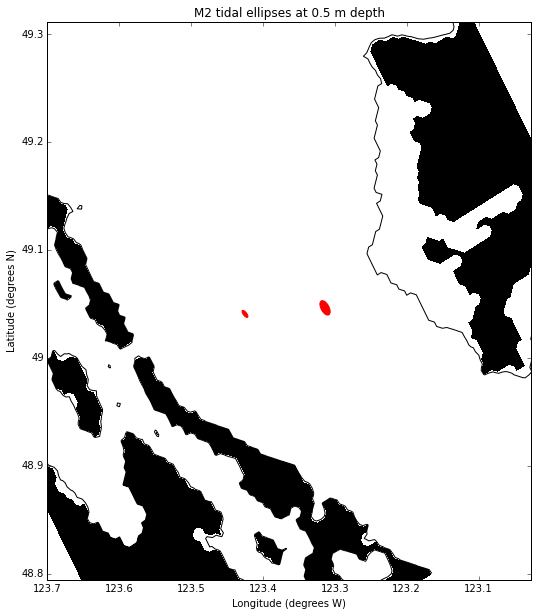

In [24]:
# rotate grid, then label axes in lats/longs

phi = 29. # the twist in the grid
k = np.zeros((898,398)); m = np.zeros((898,398))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 60

#Inverted i and j to match code
imin=416 #East node y
imax=424 #Central mode y
jmin=266 #East node x
jmax=283 #Central node x

for i in np.arange(imin-ex,imax+ex):
    for j in np.arange(jmin-ex,jmax+ex):
        k[i,j] = i*np.cos(phi*np.pi/180.)+j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.)+j*np.cos(phi*np.pi/180.) 
scale = 8.
interval = 4
depth=0
#Making the ellipse for the Central node
if ap_c[depth] > am_c[depth]:
    thec1 = 'b'
else:
    thec1 = 'r'
ells1 = Ellipse(xy=(m[imax,jmin],k[imax,jmin]), width=scale*major_c[depth], 
    height=scale*minor_c[depth], angle=theta_c[depth],
    color=thec1)

#Making the ellipse for the East node
if ap_e[depth] > am_e[depth]:
    thec2 = 'b'
else:
    thec2 = 'r'
ells2 = Ellipse(xy=(m[imin,jmax],k[imin,jmax]), width=scale*major_e[depth], 
    height=scale*minor_e[depth], angle=theta_e[depth],
    color=thec2)
    
    
ax.add_artist(ells1)
ax.add_artist(ells2)
ells1.set_facecolor(thec1)
ells2.set_facecolor(thec2)
# y-axis in k, but labelled in latitude
ax.set_ylim(445,560)
slope = (lats[imax,jmin]-lats[imin,jmin])/(k[imax,jmin]-k[imin,jmin])
mylist = (k[imin,jmin]+(np.arange(48.8, 49.35, 0.1)-
                           lats[imin,jmin])/slope).tolist()
labels = ['48.8', '48.9', '49', '49.1', '49.2', '49.3']
ax.set_yticks(mylist); ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
ax.set_xlim(-14,94)
slope = (lons[imin,jmax]-lons[imin,jmin])/(m[imin,jmax]-m[imin,jmin])
mylist = (m[imin,jmin]+(np.arange(-123.7,-123.05,0.1)-
                        lons[imin,jmin])/slope).tolist()
labels = ['123.7','123.6','123.5','123.4','123.3','123.2','123.1','123']
ax.set_xticks(mylist); ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')


# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],contour_interval,colors='black')
ax.contour(m[imin-ex:imax+ex,jmin-ex:jmax+ex],k[imin-ex:imax+ex,jmin-ex:jmax+ex],
            bathy.data[imin-ex:imax+ex,jmin-ex:jmax+ex],[5],colors='black')
ax.set_title('M2 tidal ellipses at {dep:0.1f} m depth'.format(dep=dep_t_c[depth]))

print "red is clockwise"

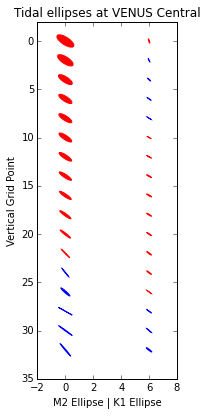

In [21]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_c[dep] > am_c[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_c[dep], 
                        height=scale*minor_c[dep], angle=-theta_c[dep],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ck[dep] > am_ck[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ck[dep], 
                        height=scale*minor_ck[dep], angle=-theta_ck[dep],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,35)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS Central')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')

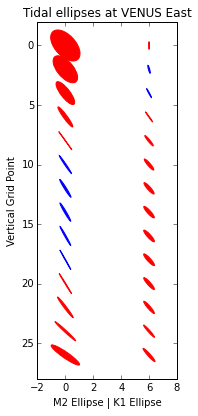

In [20]:
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2

for dep in np.arange(0,40,interval):
    if ap_e[dep] > am_e[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(0,dep), width=scale*major_e[dep], 
                        height=scale*minor_e[dep], angle=-theta_e[dep],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
    
for dep in np.arange(0,40,interval):
    if ap_ek[dep] > am_ek[dep]:
        thec = 'b'
    else:
        thec = 'r'
    ells = Ellipse(xy=(6,dep), width=scale*major_ek[dep], 
                        height=scale*minor_ek[dep], angle=-theta_ek[dep],
                        color=thec)
    ax.add_artist(ells)
    ells.set_facecolor(thec)
ax.set_ylim(-2,28)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ax.set_title('Tidal ellipses at VENUS East')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('M2 Ellipse | K1 Ellipse')

#Compare with a table

For M2 constituent

In [19]:
print "                     Central                         East"
print "Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    if major_e[i] > 0 :  
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
            major_c[i], minor_c[i], theta_c[i], major_e[i], minor_e[i],  theta_e[i])
    elif major_c[i] > 0 :
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}'.format(dep_t_c[i], 
                                                      major_c[i], minor_c[i], theta_c[i])

                     Central                         East
Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.23        -0.10       133      0.42       -0.23       124
  2.5      0.21        -0.09       133      0.37       -0.17       123
  4.5      0.19        -0.07       134      0.32       -0.10       123
  6.5      0.18        -0.06       135      0.28       -0.04       122
  8.5      0.18        -0.06       135      0.26       -0.00       121
 10.5      0.18        -0.05       134      0.25       0.02       120
 12.5      0.18        -0.05       135      0.24       0.02       118
 14.6      0.17        -0.04       135      0.24       0.02       117
 16.8      0.17        -0.04       134      0.25       0.01       116
 19.5      0.16        -0.03       133      0.26       0.01       116
 24.1      0.16       

For K1 constituent

In [18]:
print "                     Central                         East"
print "Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle "
print " (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg."
print "                                 ccw E)                          ccw E)"
for i in np.arange(0,39,interval):
    if major_ek[i] > 0 : 
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}      {4:.2f}       {5:.2f}       {6:.0f}'.format(dep_t_c[i], 
        major_ck[i], minor_ck[i], theta_ck[i], major_ek[i], minor_ek[i],  theta_ek[i])
    elif major_ck[i] > 0 :
        print '{0:5.1f}      {1:.2f}        {2:.2f}       {3:.0f}'.format(dep_t_c[i], 
                                                      major_ck[i], minor_ck[i], theta_ck[i])

                     Central                         East
Depth    Major-Axis  Minor-Axis  Angle   Major-Axis  Minor-Axis  Angle 
 (m)        (m/s)      (m/s)     (deg.    (m/s)       (m/s)      (deg.
                                 ccw E)                          ccw E)
  0.5      0.06        -0.01       103      0.09       -0.01       90
  2.5      0.05        0.00       109      0.10       0.01       103
  4.5      0.05        0.01       127      0.12       0.01       115
  6.5      0.06        0.00       134      0.13       -0.01       121
  8.5      0.06        0.00       138      0.15       -0.02       125
 10.5      0.06        -0.00       139      0.16       -0.03       126
 12.5      0.06        -0.01       141      0.17       -0.04       127
 14.6      0.06        -0.01       141      0.17       -0.04       127
 16.8      0.07        -0.01       139      0.17       -0.04       127
 19.5      0.07        -0.01       138      0.18       -0.04       127
 24.1      0.07        -

It is very similar to the 15 minutes data, only a few very slight changes, generally in the Major Axis or Minor Axis and the East node has a tendency to have more difference, maybe because the values tend to be larger. 
The longer the time the ellipses are averaged over the more the 15 minutes data and the hourly data are similar.
Same observation for K1 as for M2